# Gender Classification using SIFT Encoded Vector Dataset

### Problem statement
Given the training dataset of SIFT encoded images of people, build a classifier to predict the gender. This was a part of one of the offline (in person) hackathons I participated. The scoring metric was AUC.

### Dataset
Training, Validation and Test datasets were provided. Predictions were to be done on the test set and submitted for evaluation. The Training and Validation dataset is a csv file with Id, SIFT encoded vector representation of images (256 columns) and Label. The dataset has about 24K rows and 258 columns. The dataset was skewed with almost 80% of the rows for one class (Label 1) and 20% for the other (Label 0).

### Approach
* Did train split into train and cross validation for evaluation. Didn't use Validation set right in the begining. 
* Balance out the dataset:
    * This can be done in one of the two ways...
        * Remove class 1 rows to bring down the row count close to that of class 2. This approach can be chosen if training size/hardware limitation is a problem and unless this won't reduce dataset drastically.
        * Oversample for class 2 rows by adding copy of the randomly chosen rows repeatedly to bring the count close to that of class 1. Shuffle records in class 2, to prevent any kind of uniformity introduced while adding the rows repeatedly.
* Dimensionality Reduction based on Feature importances:
    * In any dataset, even before thinking of feature engineering, we should first identify the importance of all the features. Not all of them are useful. And limiting to the most important features always makes a lot of difference. 
    * I used PCA and SelectKBest. Both gave almost similar results.
    * I did this by choosing _n_ best features using SelectKBest() iteratively for _n_ ranging between 30 to 256, with stepping interval of 5. This gave me the best _n_ based on the highest AUC score.

#### Possible Improvements
* Use stratified sampling for cross validation
* Use PCA and SelectKBest together to find the best features, stepping at every feature instead of having bigger steps
* Perform grid search to tune hyper parameters better
* Use Model Stacking with other types of classifiers like SVM, ANN, etc.
* Consider Autoencoders for feature extraction and dimensionality reduction

### Quick info about SIFT
SIFT stands for Scale-invariant feature transform. SIFT is used to encode images into vectors. This representation is different from raw flattened out pixels that are widely used. The main shortcoming of the raw pixel representation of images is that, the pixel data doesn't preserve/represent similarities across images. For instance, even the slight change in the image's aspect ratio or angle of view changes the pixels drastically, even when the image is same.

#### References
* [Scale-invariant feature transform - Wikipedia](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) 

In [1]:
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
trainPath = os.getcwd() + '\\dataset\\Train.csv'
testPath = os.getcwd() + '\\dataset\\TestData.csv'
validationPath = os.getcwd() + '\\dataset\Validate.csv'

trainDf = pd.read_csv(trainPath)
testDf = pd.read_csv(testPath)
validateDf = pd.read_csv(validationPath)

In [3]:
trainDf.shape

(23491, 258)

In [4]:
testDf.shape

(8192, 257)

In [5]:
validateDf.shape

(4567, 258)

In [6]:
trainDf['Label'].value_counts()

1    18792
0     4699
Name: Label, dtype: int64

In [7]:
train = trainDf
test = testDf
valid = validateDf

for i in range(5):
    train = train.append(train.loc[train['Label'] == 0].sample(2800))

train = shuffle(train)

sample_size = train['Label'].shape[0]
distribution = train['Label'].value_counts()

male_percent = (distribution[1]/sample_size) * 100
female_percent = (distribution[0]/sample_size) * 100

print('Male   : ' + str(distribution[1]) + ', ' + ("{0:.4f}".format(male_percent)) + '%')
print('Female : ' + str(distribution[0]) + ', ' + ("{0:.4f}".format(female_percent)) + '%')

Male   : 18792, 50.1240%
Female : 18699, 49.8760%


In [8]:
X = np.array(train.drop(['Id', 'Label'], 1))
y = np.array(train['Label'])
X = preprocessing.scale(X)

X_Valid = np.array(validateDf.drop(['Id', 'Label'], 1))
y_Valid = np.array(validateDf['Label'])
X_Valid = preprocessing.scale(X_Valid)

finalTest = np.array(testDf.drop(['Id'], 1))
finalTest = preprocessing.scale(finalTest)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
xgClf = XGBClassifier(
            base_score=0.5,
            colsample_bylevel=1,
            colsample_bytree=1,
            gamma=1,
            learning_rate=0.1,
            max_delta_step=0,
            max_depth=3,
            min_child_weight=1,
            missing=None,
            n_estimators=500,
            nthread=-1,
            objective='binary:logistic',
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=0,
            silent=False,
            subsample=1)

xgClf.fit(X_train, y_train, eval_metric='auc', verbose=True)
print('Training complete')

Training complete


In [10]:
preds = pd.DataFrame(xgClf.predict_proba(X_test))
print('ROC_AUC: ' + metrics.roc_auc_score(np.array(y_test), np.array(preds[[1]])).astype(str))
pd.DataFrame(preds).head(5)

ROC_AUC: 0.9857892578039102


,0,1
0,0.018419,0.981581
1,0.975553,0.024447
2,0.992351,0.007649
3,0.041392,0.958608
4,0.283994,0.716006


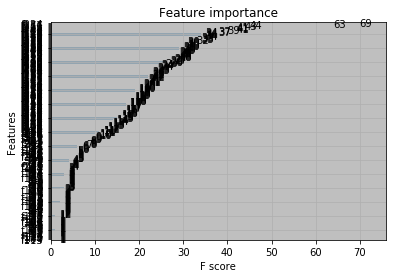

In [11]:
# XGBoost inbuilt plot
plot_importance(xgClf)
plt.show()

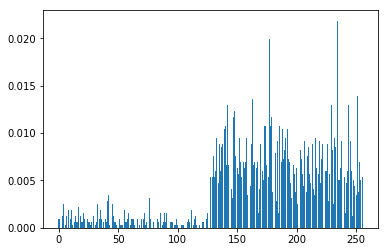

In [12]:
# Manually plotting using matplotlib
plt.bar(range(len(xgClf.feature_importances_)), xgClf.feature_importances_)
plt.show()

In [13]:
#Reduced the range to run this quickly and get outputs to upload to GitHub
features = [110] #[i for i in range(110, 250, 10)]
features = np.array(features)
optFeat = -1
maxRoc = -1

for imp_feat in features:
    print('Selecting ' + str(imp_feat) + ' best...')
    feat_selector = SelectKBest(score_func=f_classif, k=imp_feat)
    fit = feat_selector.fit(X_train, y_train)
    X_train_train = fit.transform(X_train)
    
    print('Training with ' + str(imp_feat) + ' best...')
    xgClf.fit(X_train_train, y_train, eval_metric='auc', verbose=True)

    print('Transform, predict...')
    X_test_trans = fit.transform(X_test)
    y_test_pred = xgClf.predict_proba(X_test_trans)
    predictions = [round(value[1]) for value in y_test_pred]
    y_test_pred = [value[1] for value in y_test_pred]
    
    print('Scoring...')
    accuracy = metrics.accuracy_score(y_test, predictions)
    auc = metrics.average_precision_score(np.array(y_test), np.array(y_test_pred))
    roc = metrics.roc_auc_score(np.array(y_test), np.array(y_test_pred))
    
    if (roc > maxRoc):
        maxRoc = roc
        optFeat = imp_feat
    
    print("Features=%.6f, n=%d, Accuracy: %.2f%%, auc: %.6f, roc: %.6f" % (imp_feat, X_test_trans.shape[1], accuracy*100.0, auc, roc))

print("Best Features=%.6f" %(optFeat))

Selecting 110 best...
Training with 110 best...
Transform, predict...
Scoring...
Features=110.000000, n=110, Accuracy: 95.14%, auc: 0.986324, roc: 0.985504
Best Features=110.000000


In [14]:
np.set_printoptions(precision=6)
feat_selector = SelectKBest(score_func=f_classif, k=110)
fit = feat_selector.fit(X_train, y_train)

In [15]:
#X_train_trans = fit.transform(X_train)
X_train_trans = X_train
xgClf.fit(X_train_trans, y_train, eval_metric='auc', verbose=True)
scoreX = None
scoreY = None
scoreP = None

In [16]:
#X_test_trans = fit.transform(X_test)
X_test_trans = X_test
pred_test = xgClf.predict_proba(X_test_trans)
scoreX = X_test_trans
scoreY = y_test
scoreP = pred_test
pd.DataFrame(pred_test).head(5)

,0,1
0,0.018419,0.981581
1,0.975553,0.024447
2,0.992351,0.007649
3,0.041392,0.958608
4,0.283994,0.716006


In [17]:
#X_Valid_trans = fit.transform(X_Valid)
X_Valid_trans = X_Valid
pred_valid = xgClf.predict_proba(X_Valid_trans)
scoreX = X_Valid_trans
scoreY = y_Valid
scoreP = pred_valid
pd.DataFrame(pred_valid).head(5)

,0,1
0,0.023477,0.976523
1,0.010117,0.989883
2,0.025596,0.974404
3,0.996968,0.003032
4,0.181958,0.818042


In [18]:
#finalTest_trans = fit.transform(finalTest)
finalTest_trans = finalTest
pred_finalTest = xgClf.predict_proba(finalTest_trans)
scoreX = finalTest_trans
scoreY = None
scoreP = pred_finalTest
pd.DataFrame(pred_finalTest).head(5)

,0,1
0,0.987994,0.012006
1,0.012539,0.987461
2,0.034119,0.965881
3,0.468343,0.531657
4,0.005880,0.994120


In [19]:
def predict_Score(X, y, p):
    predictions_ = [round(value[1]) for value in p]
    accuracy_ = metrics.accuracy_score(y, predictions_)
    auc_ = metrics.average_precision_score(np.array(y), np.array(p[:,1]))
    roc_ = metrics.roc_auc_score(np.array(y), np.array(p[:,1]))
    print("Final Thresh: %.6f, n: %d, Accuracy: %.2f%%, auc:%.6f, roc_auc: %.6f" % (258, X.shape[1], accuracy_*100.0, auc_, roc_))

if(scoreX != None and scoreY != None and scoreP != None):
    predict_Score(scoreX, scoreY, scoreP)
else:
    print('Test set cannot be scored')

Test set cannot be scored


In [20]:
sub = pd.DataFrame(pred_finalTest)
sub.insert(loc=0, column='Id', value=testDf['Id'])
sub[['Id',1]].to_csv('result.csv', index=False, header=['Id', 'Score'])
sub[['Id',1]].head(5)

,Id,1
0,19abee57-99ca-5636-9118-e3bb58b88848,0.012006
1,3d6f9293-ac9f-5fad-9cc5-f47bbe25bdef,0.987461
2,2599edee-e030-5b23-9aaa-5338cdf2a6e9,0.965881
3,503a89e5-06fd-5ae0-a644-d1aa172faa70,0.531657
4,c3b2305e-de61-5b62-ae6b-52c396d7b247,0.994120
